In [1]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [3]:
BATCH_SIZE = 5

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [6]:
transfer_model = VGG16(weights='imagenet', include_top=False,
                      input_shape=(150, 150, 3))

transfer_model.trainable = False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [8]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(layers.Flatten())
finetune_model.add(layers.Dense(64, activation='relu'))
finetune_model.add(layers.Dropout(0.5))
finetune_model.add(layers.Dense(1, activation='sigmoid'))
finetune_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002),
             metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [11]:
h = finetune_model.fit(train_generator, epochs=100, validation_data=test_generator,
             callbacks=[early_stopping])

Epoch 1/100
32/32 [==============================] - 8s 237ms/step - loss: 0.6649 - accuracy: 0.5875 - val_loss: 0.5569 - val_accuracy: 0.8500
Epoch 2/100
32/32 [==============================] - 7s 218ms/step - loss: 0.6011 - accuracy: 0.7000 - val_loss: 0.4980 - val_accuracy: 0.8667
Epoch 3/100
32/32 [==============================] - 7s 220ms/step - loss: 0.4723 - accuracy: 0.8375 - val_loss: 0.4212 - val_accuracy: 0.9000
Epoch 4/100
32/32 [==============================] - 7s 218ms/step - loss: 0.4494 - accuracy: 0.8313 - val_loss: 0.3821 - val_accuracy: 0.8667
Epoch 5/100
32/32 [==============================] - 7s 226ms/step - loss: 0.4150 - accuracy: 0.8188 - val_loss: 0.3434 - val_accuracy: 0.9250
Epoch 6/100
32/32 [==============================] - 7s 214ms/step - loss: 0.3778 - accuracy: 0.8375 - val_loss: 0.3088 - val_accuracy: 0.9083
Epoch 7/100
32/32 [==============================] - 7s 207ms/step - loss: 0.3165 - accuracy: 0.8938 - val_loss: 0.2805 - val_accuracy: 0.9167

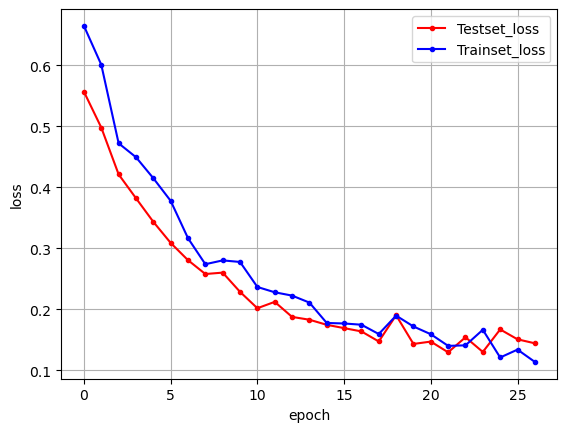

In [12]:
y_vloss = h.history['val_loss']
y_loss = h.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()